## 练习

1. 改进本节实验中的模型。
    1. 是否包含了过去$4$个以上的观测结果？真实值需要是多少个？
    1. 如果没有噪音，需要多少个过去的观测结果？提示：把$\sin$和$\cos$写成微分方程。
    1. 可以在保持特征总数不变的情况下合并旧的观察结果吗？这能提高正确度吗？为什么？
    1. 改变神经网络架构并评估其性能。
1. 一位投资者想要找到一种好的证券来购买。他查看过去的回报，以决定哪一种可能是表现良好的。这一策略可能会出什么问题呢？
1. 时间是向前推进的因果模型在多大程度上适用于文本呢？
1. 举例说明什么时候可能需要隐变量自回归模型来捕捉数据的动力学模型。

epoch 1, loss: 0.054908
epoch 2, loss: 0.050184
epoch 3, loss: 0.048919
epoch 4, loss: 0.048152
epoch 5, loss: 0.056232


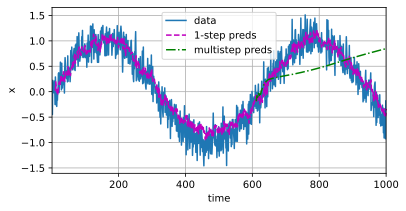

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 数据生成
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

# 扩展观测窗口大小
tau = 10
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

# 划分数据集
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 定义一个更复杂的网络
def get_net():
    net = nn.Sequential(nn.Linear(tau, 20), nn.ReLU(),
                        nn.Linear(20, 10), nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失函数
loss = nn.MSELoss(reduction='none')

# 训练函数
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

# 训练模型
net = get_net()
train(net, train_iter, loss, 5, 0.01)

# 进行预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

# 多步预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

# 绘制多步预测结果
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

### 2. 投资者使用过去回报决定购买的问题

这种策略的一个主要问题是它假设过去的表现会预示未来的结果，这在许多情况下并不可靠。市场条件、经济因素和其他外部影响都可能发生变化，导致过去的表现不再是未来表现的可靠指标。

### 3. 时间是向前推进的因果模型在多大程度上适用于文本

在文本分析中，时间序列模型（如自回归模型）可以捕捉到文本中的顺序信息，这在某些应用中是有用的，例如语言建模或文本生成。然而，文本中的因果关系可能更为复杂，不仅仅是简单的时间顺序。上下文、语义关系和长期依赖都是文本中重要的方面，可能需要更复杂的模型来捕捉。

### 4. 需要隐变量自回归模型来捕捉数据动力学模型的例子

隐变量自回归模型在捕捉那些不仅仅由可观测变量驱动的复杂动态系统时非常有用。例如，在金融市场分析中，市场的动态可能受到多种隐性因素的影响，如投资者情绪、政治事件或宏观经济指标的变化。在这些情况下，模型需要捕捉这些隐性因素的动态以及它们如何影响可观测的市场行为。